# Fine tuning

Now we've found the best classification, let's fit the slider values to obtain the best model!

First, set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import json
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import lib.galaxy_utilities as gu
import lib.python_model_renderer.render_galaxy as rg
import fit_model as fm
from IPython.display import clear_output

/Users/tlingard/PhD/galaxy-builder/data-aggregation/model-scoring/lib/galaxy_utilities.py:100: UserWarning: Using montaged image
  __import__('warnings').warn('Using montaged image')


In [3]:
print('Working on', fm.subject_id)

Working on 20902040


Grab the annotation to work on (`example_annotation.json`)

In [4]:
annotation = fm.load_data()

Render the model drawn by the volunteer:

In [5]:
disk, bulge, bar = [
    rg.sersic_comp(a, image_size=fm.image_size, oversample_n=1)
    for a in (annotation['disk'], annotation['bulge'], annotation['bar'])
]
spirals = np.add.reduce([
    rg.spiral_arm(*s, annotation['disk'], image_size=fm.image_size)
    for s in annotation['spiral']
])

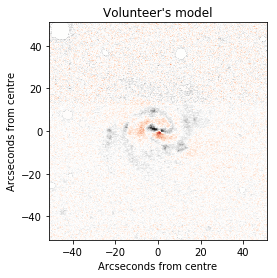

In [165]:
model = rg.convolve2d(disk + bulge + bar + spirals, fm.psf, mode='same', boundary='symm')
plt.imshow(
    fm.galaxy_data - model,
    vmin=-0.2, vmax=0.2, cmap='RdGy',
    extent=fm.imshow_kwargs['extent']
)
plt.xlabel('Arcseconds from centre')
plt.ylabel('Arcseconds from centre')
plt.title('Volunteer\'s model')
None

## Fitting

We'll work backwards through the model (spiral arms then bar then bulge then disk), tuning all sliders as we go.

In [174]:
better_spirals = fm.fit_spirals(
    annotation['spiral'], annotation['disk'],
    disk+bulge+bar, fm.galaxy_data, fm.psf
)
new_spiral_params = [
    {
        fm.spiral_params[j]: better_spirals[i]['x'][j]
        for j in range(len(better_spirals[i]['x']))
    }
    for i in range(len(annotation['spiral']))
]
new_spiral_params

KeyError: 1

In [8]:
new_spirals = np.add.reduce([
    rg.spiral_arm(*s, annotation['disk'], image_size=fm.image_size)
    for s in new_spiral_params
])

In [9]:
better_bar = fm.fit_comp(annotation['bar'], disk+bulge+new_spirals,
                         fm.galaxy_data, fm.psf,
                         c_to_fit=('i0', 'rEff', 'n', 'c'))
new_bar_params = {
    fm.param_list[i]: better_bar['x'][i]
    for i in range(len(better_bar['x']))
}
new_bar_params

{'i0': 0.14821648063840878,
 'rEff': 5.107775481303139,
 'n': 0.1491045472827775,
 'c': 5.781983406466953}

In [10]:
new_bar = rg.sersic_comp(
    {**annotation['bar'], **new_bar_params},
    image_size=fm.image_size, oversample_n=3
)

In [11]:
better_bulge = fm.fit_comp(annotation['bulge'], disk+new_bar+new_spirals,
                           fm.galaxy_data, fm.psf,
                           c_to_fit=('i0', 'rEff', 'n'))
new_bulge_params = {
    fm.param_list[i]: better_bulge['x'][i]
    for i in range(len(better_bulge['x']))
}
new_bulge_params

{'i0': 0.8049525803386564,
 'rEff': 10.037964362526882,
 'n': 0.44071161955344873}

In [12]:
new_bulge = rg.sersic_comp(
    {**annotation['bulge'], **new_bulge_params},
    image_size=fm.image_size, oversample_n=3
)

In [13]:
better_disk = fm.fit_comp(annotation['disk'], new_bulge+new_bar+new_spirals,
                          fm.galaxy_data, fm.psf,
                          c_to_fit=('i0', 'rEff'))
new_disk_params = {
    fm.param_list[i]: better_disk['x'][i]
    for i in range(len(better_disk['x']))
}
new_disk_params

{'i0': 0.11318458771527994, 'rEff': 127.3398110713704}

In [14]:
new_disk = rg.sersic_comp(
    {**annotation['disk'], **new_disk_params},
    image_size=fm.image_size, oversample_n=3
)

Have we hit the limits on any of the parameters?

In [21]:
print('Disk:  ', any(better_disk['active_mask']))
print('Bulge: ', any(better_bulge['active_mask']))
print('Bar:   ', any(better_bar['active_mask']))
print('Spiral:', any([any(i['active_mask']) for i in better_spirals]))

Disk:   False
Bulge:  False
Bar:    False
Spiral: False


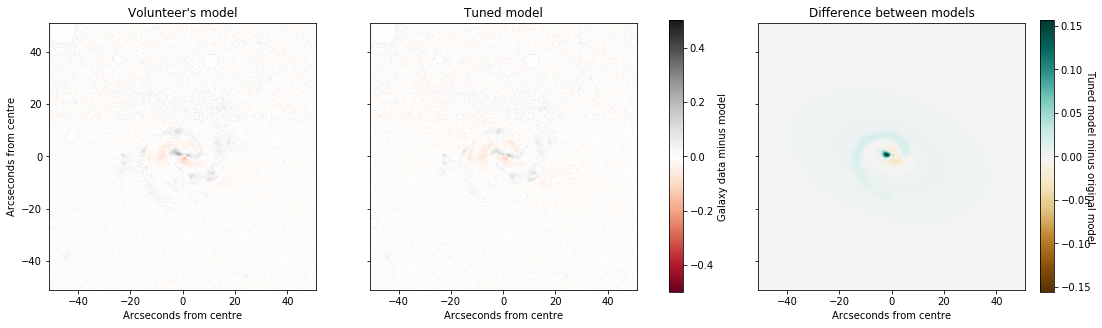

In [173]:
new_model = rg.convolve2d(
    new_disk + new_bulge + new_bar + new_spirals,
    fm.psf, mode='same', boundary='symm'
)
fig, ax = plt.subplots(ncols=3, sharey=True, sharex=True, figsize=(18, 5))
ax[0].set_title('Volunteer\'s model')
ax[0].imshow(
    fm.galaxy_data - model,
    vmin=-0.5, vmax=0.5, cmap='RdGy',
    extent=fm.imshow_kwargs['extent']
)
ax[1].set_title('Tuned model')
tuned_im = ax[1].imshow(
    fm.galaxy_data - new_model,
    vmin=-0.5, vmax=0.5, cmap='RdGy',
    extent=fm.imshow_kwargs['extent']
)
c = plt.colorbar(tuned_im, ax=ax[:-1], fraction=0.046, pad=0.04)
c.ax.set_ylabel('Galaxy data minus model', rotation=90)
diff_im = ax[2].imshow(
    new_model - model,
    vmin=-np.max(np.abs(new_model - model)),
    vmax=np.max(np.abs(new_model - model)),
    cmap='BrBG',
    extent=fm.imshow_kwargs['extent']
)
ax[2].set_title('Difference between models')

ax[0].set_ylabel('Arcseconds from centre')
for a in ax:
    a.set_xlabel('Arcseconds from centre')
c = plt.colorbar(diff_im, ax=ax[-1], fraction=0.046, pad=0.04)
c.ax.set_ylabel('Tuned model minus original model', rotation=90)

None

And there we go, looks like the volunteer was pretty close already - so kudos to them!

In [177]:
from copy import deepcopy
new_annotation = deepcopy(annotation)
new_annotation['disk'].update(new_disk_params)
new_annotation['bulge'].update(new_bulge_params)
new_annotation['bar'].update(new_bar_params)
for i in range(len(new_annotation['spiral'])):
    new_annotation['spiral'][i][1].update(new_spiral_params[i])

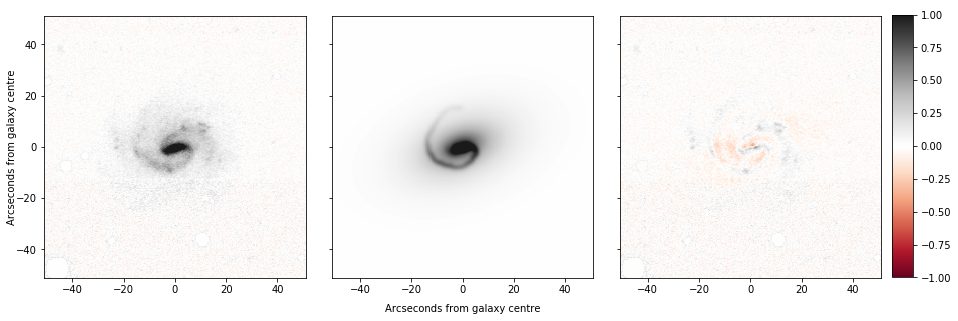

In [209]:
_ = rg.plot_model(
    rg.calculate_model(new_annotation, fm.image_size, 5),
    fm.psf,
    fm.galaxy_data,
    fm.imshow_kwargs,
)

In [208]:
import string
f = string.Formatter()
list(f.parse('Well hi there {name}, how are you? {0[weight]:.2f}'))

[('Well hi there ', 'name', '', None),
 (', how are you? ', '0[weight]', '.2f', None)]